## Homework 3: Mean Shift

**Due date:** November 12th 2019

The goal of the assignment is to implement the mean shift algorithm and use it for image segmentation. You should return the completed notebook, including answers and illustrations. 


**Part 1: mean shift on synthetic data**

* Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.
* Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.
* Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.
* Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.
* Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.
* Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
* Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

**Part 2: mean shift for image segmentation**

* For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg`, and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 
* Convert the (N,M,3) image into an (NM,5) matrix incuding color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?
* Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

## Part 1

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from skimage.color import rgb2lab,lab2rgb

In [2]:
data = np.vstack((np.random.multivariate_normal(mean=[0,0], cov=np.eye(2), size=60), \
              np.random.multivariate_normal(mean=[4,4], cov=np.eye(2), size=40)))

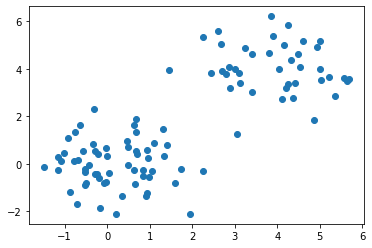

In [3]:
plt.scatter(data[:, 0], data[:, 1])

$K(t) = e^{\frac{-t}{2}}, K'(x) = -e^{\frac{t}{2}}/2$

In [4]:
def G(x, h):
    if x.ndim == 1: # d=1
        return np.exp((-(x/h)**2)/2) / 2
    if x.ndim == 2: # d=2
        return np.exp((-np.linalg.norm(x/h, axis=1)**2)/2) / 2

In [5]:
def MS_step(x, data, h, kernel):
    return (data*kernel(x-data, h).reshape(-1, 1)).sum(0) / kernel(x-data, h).sum(0)

In [6]:
def MS_point(x, data, h, kernel, tol=1e-3):
    error = np.infty
    while error > tol:
        prev = x.copy()
        x = MS_step(x, data, h, kernel)
        error = np.linalg.norm(x-prev)
    return x

In [7]:
start = data[1]
end = MS_point(start, data, h=2, kernel=G, tol=1e-6)

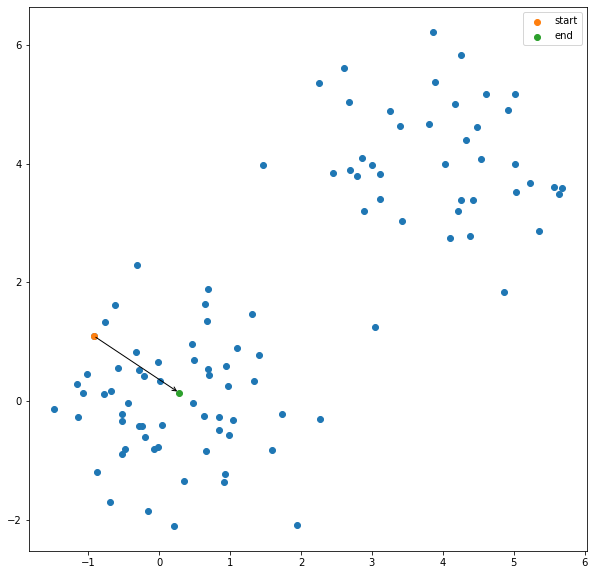

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(*start, label="start")
plt.scatter(*end, label="end")
plt.annotate(text='', xy=start, xytext=end, arrowprops=dict(arrowstyle='<-'))
plt.legend()

In [9]:
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform

In [10]:
def MS_full(data, kernel, h=1, tol=1e-6, distance=1e-5):
    flag = np.array([False for i in range(len(data))])
    labels = np.array([-1 for i in range(len(data))])
    ends = []
    count = 0
    modes = {}
    
    for point in data:
        start = point.copy()
        end = MS_point(start, data, h, kernel, tol=tol)
        ends.append(end)
        
    d = squareform(pdist(ends))
    for i, row in enumerate(d):
        if flag[i] == False:
            merge_idx = np.where(row < distance)
            flag[merge_idx] = True
            labels[merge_idx] = count
            modes[count] = np.asarray(ends)[merge_idx].mean(axis=0)
            count += 1
    assert flag.all()
    return modes, labels

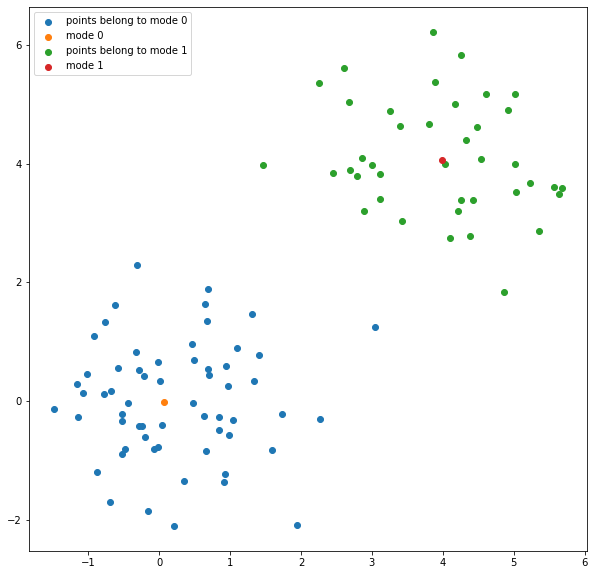

In [11]:
modes, labels = MS_full(data, kernel=G, h=1)
plt.figure(figsize=(10, 10))
for label, mode in modes.items():
    msk = labels == label
    plt.scatter(data[msk, 0], data[msk, 1], label="points belong to mode " +str(label))
    plt.scatter(*mode, label="mode "+str(label))
    plt.legend()

### change data distribution

In [12]:
data = np.vstack((np.random.multivariate_normal(mean=[0,0], cov=np.eye(2), size=60), \
              np.random.multivariate_normal(mean=[2,2], cov=np.eye(2), size=40)))

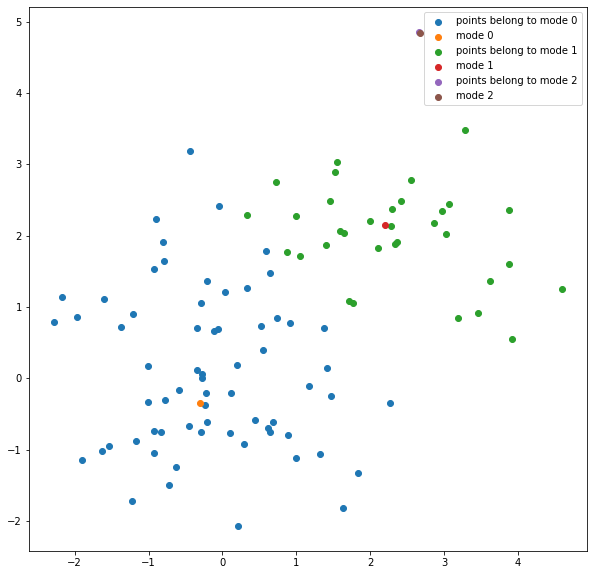

In [13]:
modes, labels = MS_full(data, kernel=G, h=0.5)
plt.figure(figsize=(10, 10))
for label, mode in modes.items():
    msk = labels == label
    plt.scatter(data[msk, 0], data[msk, 1], label="points belong to mode " +str(label))
    plt.scatter(*mode, label="mode "+str(label))
    plt.legend()

### change bandwidth

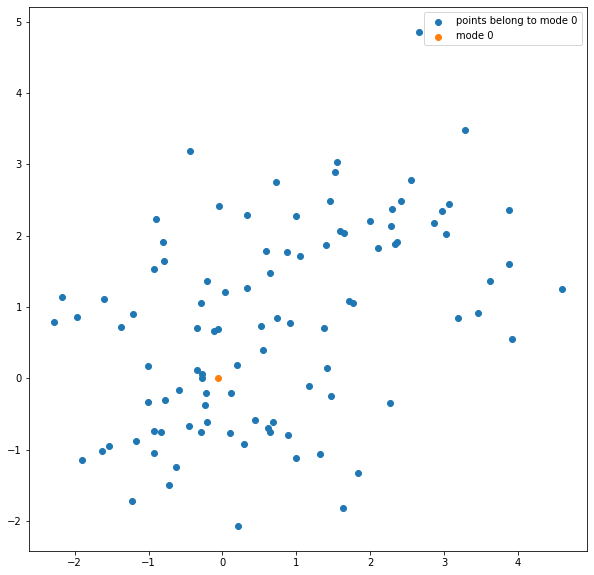

In [14]:
modes, labels = MS_full(data, kernel=G, h=1)
plt.figure(figsize=(10, 10))
for label, mode in modes.items():
    msk = labels == label
    plt.scatter(data[msk, 0], data[msk, 1], label="points belong to mode " +str(label))
    plt.scatter(*mode, label="mode "+str(label))
    plt.legend()

### change kernel

In [15]:
def E(x, h):
    res = np.zeros(x.shape[0])
    idx = np.linalg.norm(x/h, axis=1) ** 2 < 1
    res[idx] = 1
    return res

In [16]:
data = np.vstack((np.random.multivariate_normal(mean=[0,0], cov=np.eye(2), size=60), \
              np.random.multivariate_normal(mean=[4,4], cov=np.eye(2), size=40)))

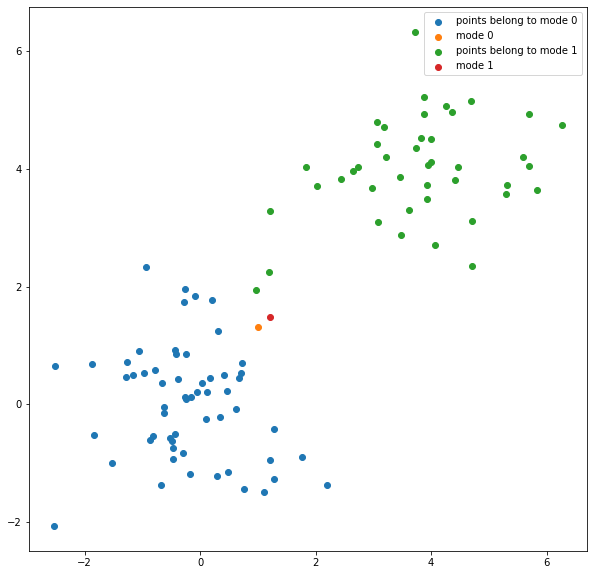

In [17]:
modes, labels = MS_full(data, kernel=E, h=4.8)
plt.figure(figsize=(10, 10))
for label, mode in modes.items():
    msk = labels == label
    plt.scatter(data[msk, 0], data[msk, 1], label="points belong to mode " +str(label))
    plt.scatter(*mode, label="mode "+str(label))
    plt.legend()

## Part 2

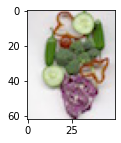

In [18]:
plt.figure(figsize=(2, 2))
plt.imshow(plt.imread("veggies_small.jpg"))

In [19]:
veggies = rgb2lab(plt.imread("veggies_small.jpg"))

In [20]:
np.max(veggies.reshape(-1, 3), axis=0)

array([97.23209972, 43.95147935, 51.40709947])

In [21]:
np.min(veggies.reshape(-1, 3), axis=0)

array([  1.76470126, -34.86842703, -22.86604169])

L (0-100), a (-128-127), b (-128-127)

In [22]:
xx, yy = np.meshgrid(np.arange(veggies.shape[0]), np.arange(veggies.shape[1]), indexing="ij")

In [23]:
pairs = np.vstack([xx.reshape(-1), yy.reshape(-1)])

In [24]:
pairs.T

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       ...,
       [61, 47],
       [61, 48],
       [61, 49]])

In [25]:
M = np.concatenate([veggies.reshape(-1, 3), pairs.T], axis=1)

In [26]:
M.shape

(3100, 5)

In [27]:
M[130]

array([ 71.3555945 , -15.88439768,  20.97927479,   2.        ,
        30.        ])

In [29]:
veggies[2, 30, :]

array([ 71.3555945 , -15.88439768,  20.97927479])

### I decide to use bandwidth vector $h=[5,5,5,10,10]$ so that we pay more attention to the differences in lighting and color and less attention to the positional information.

In [30]:
h = np.array([5, 5, 5, 10, 10])

In [31]:
modes, labels = MS_full(data=M, kernel=G, h=h, tol=1e-5, distance=1e-5)

In [32]:
len(modes)

34

In [33]:
mode_colors = {}
for label, array in modes.items():
    mode_colors[label] = array[:3]

In [34]:
segmentation = np.zeros(shape=(M.shape[0], 3))

In [35]:
for i, row in enumerate(segmentation):
    color = mode_colors[labels[i]]
    segmentation[i] = color

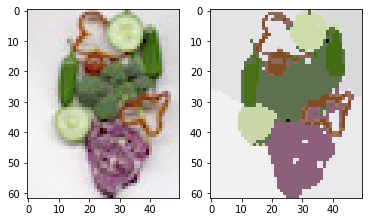

In [36]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(plt.imread("veggies_small.jpg"))
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(segmentation.reshape(62, 50, -1)))